In [1]:
# !pip install dtaidistance

In [2]:
# ✅ [1] 필수 패키지 임포트
import os
import pandas as pd
import numpy as np
import random
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from scipy.stats import wasserstein_distance, energy_distance
from scipy.spatial import distance
from sklearn import metrics

from dtaidistance import dtw  # pip install dtaidistance
from tqdm import tqdm
import torch

In [3]:
def dummy_creation(dataset, dummy_categories):
    for i in dummy_categories:
        dataset_dummy = pd.get_dummies(dataset[i])

        dataset=pd.concat([dataset,dataset_dummy],
                          axis=1)
        dataset=dataset.drop(i,axis=1)
    return dataset

## 1. 데이터 불러오기 (Load a Dataset)

Data Source: https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill

In [4]:

# 데이터셋이 저장된 Google Drive 내 폴더 경로 지정
FOLDER_DIR = "./dataset-SMART"

In [5]:
# 개별 실험 데이터를 저장할 리스트 초기화
experiments = []

# 폴더 내 파일들을 순회
for file_name in os.listdir(FOLDER_DIR):
  if file_name.startswith("experiment"):
    df = pd.DataFrame()  # 빈 데이터프레임 생성 (선택사항)

    df = pd.read_csv(f"{FOLDER_DIR}/{file_name}", index_col=None, header=0)

    # 파일명에서 실험 번호 추출하여 'Experiment' 컬럼에 추가 (예: experiment02.csv → 2)
    df['Experiment'] = int(file_name[-6:-4])
    experiments.append(df)

# 개별 실험 데이터를 하나의 데이터프레임으로 병합
df_raw_original = pd.concat(experiments, axis=0, ignore_index=True)

In [6]:
# 메타데이터 CSV 파일 읽기 (조건 정보 포함)
df_meta = pd.read_csv(os.path.join(FOLDER_DIR, "train.csv"))

# tool_condition, clamp_pressure, feedrate 순으로 정렬
df_meta = df_meta.sort_values(by=['tool_condition', 'clamp_pressure', 'feedrate'])

# tool_condition이 'worn'이면 1, 아니면 0으로 라벨링 >>> 1이면 마모됨. 0이면 정상
df_meta['label'] = df_meta['tool_condition'].apply(lambda x: 1 if x == "worn" else 0)

# feedrate와 clamp_pressure를 조합해 WorkingCondition이라는 새로운 컬럼 생성 >>> 이동속도와 클램핑 압력열을 조합한 파생 변수 생성. ex) 3-2.5
df_meta['WorkingCondition'] = df_meta['feedrate'].apply(lambda x: str(x)) + "-" + df_meta['clamp_pressure'].apply(lambda x: str(x))


In [7]:
df_raw = dummy_creation(df_raw_original, ['Machining_Process'])

df_raw['label'] = 0         ## 공구 상태가 정상
df_raw['label'] = df_raw['Experiment'].apply(lambda x: df_meta[df_meta['No'] == x]['label'].values[0])      # 실험번호와 라벨 맞추기

no_wc_dict = dict(zip(df_meta['No'], df_meta['WorkingCondition']))

df_raw['WorkingCondition'] = df_raw['Experiment'].apply(lambda x: no_wc_dict[x])

## 2. 데이터 전처리

### 2-1. 센서 데이터만

In [8]:
col_sensor = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage',
       'S1_OutputPower', 'S1_SystemInertia']

col_bn = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage',
       'S1_OutputPower', 'S1_SystemInertia','feedrate','clamp_pressure','layer']

col_CNCCode = ['M1_CURRENT_PROGRAM_NUMBER',
       'M1_sequence_number', 'M1_CURRENT_FEEDRATE', 'Experiment', 'End',
       'Layer 1 Down', 'Layer 1 Up', 'Layer 2 Down', 'Layer 2 Up',
       'Layer 3 Down', 'Layer 3 Up', 'Prep', 'Repositioning', 'Starting',
       'end', 'label']

Issue :    
- M1_CURRENT_FEEDRATE == 50   
- X1 ActualPosition == 198   
- M1_CURRENT_PROGRAM_NUMBER !=0

해당 조건에 해당하는 값들은 오류 및 이상치가 포함된 데이터로 추측된다고 함.   

> Note that some variables will not accurately reflect the operation of the CNC machine. This can usually be detected by when M1_CURRENT_FEEDRATE reads 50, when X1 ActualPosition reads 198, or when M1_CURRENT_PROGRAM_NUMBER does not read 0. The source of these errors has not been identified.   
https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill

하지만 현재 실험에서 배제하지 않고 진행함.

### 2-2. 공구 마모와 유관한 구간만 필터링

In [9]:
# 절삭 구간만 자르기 -> 공구 마모와 관련된 구간
layer_cols = ['Layer 1 Down', 'Layer 1 Up', 'Layer 2 Down', 'Layer 2 Up', 'Layer 3 Down', 'Layer 3 Up']
df_raw['Layer_Total'] = df_raw[layer_cols].sum(axis=1)  # axis=1로 행 방향 합계
df_layer = df_raw[df_raw['Layer_Total'] > 0].copy() # .copy()를 사용하여 복사본 생성

# Layer to Working Conditions
df_layer.loc[:, 'Layer1'] = df_layer[['Layer 1 Down', 'Layer 1 Up']].sum(axis=1)
df_layer.loc[:, 'Layer2'] = df_layer[['Layer 2 Down', 'Layer 2 Up']].sum(axis=1)
df_layer.loc[:, 'Layer3'] = df_layer[['Layer 3 Down', 'Layer 3 Up']].sum(axis=1)

df_layer.loc[:, 'Layer_Info'] = df_layer[['Layer1', 'Layer2', 'Layer3']].idxmax(axis=1)  # idxmax로 최대값 컬럼명 가져오기
df_layer.loc[:, 'Layer_Info'] = df_layer['Layer_Info'].map({'Layer1': 1, 'Layer2': 2, 'Layer3': 3})  # 컬럼명을 숫자로 매핑

# Scenario = Experiment (Load X Speed X Label) X Layer
df_layer.loc[:, 'SCN'] = df_layer['Experiment'].astype(str) + "-" + df_layer['Layer_Info'].astype(str)  # 문자열로 변환하여 결합

## 3. 데이터 시각화 (Data Visualization)

### 3-0. 절삭 구간

C:\Users\DANIK\AppData\Local\Temp\ipykernel_15880\1021785592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_process['Process_Numeric'] = df_process['Machining_Process'].map(process_mapping)


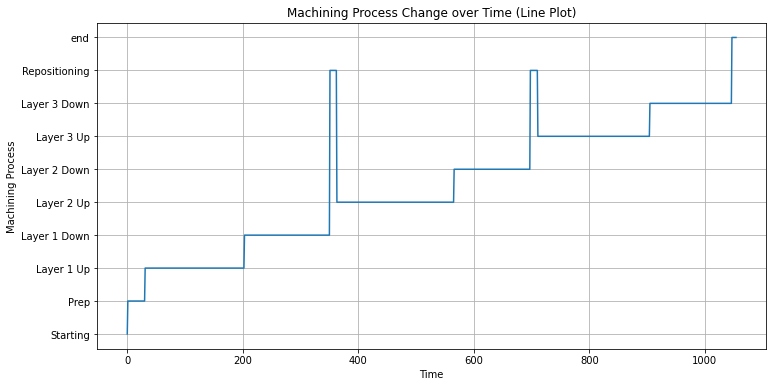

In [10]:
# 데이터프레임에서 필요한 컬럼만 선택
df_process = df_raw_original[df_raw_original["Experiment"] == 1]

# Machining_Process 컬럼을 숫자로 변환 (Scatter plot에 필요)
process_mapping = {
    'Layer 1 Up': 2,
    'Layer 1 Down': 3,
    'Layer 2 Up': 4,
    'Layer 2 Down': 5,
    'Layer 3 Up': 6,
    'Layer 3 Down': 7,
    'Repositioning': 8,
    'Prep': 1,
    'Starting': 0,
    'end': 9
}
df_process['Process_Numeric'] = df_process['Machining_Process'].map(process_mapping)

plt.figure(figsize=(12, 6))
plt.plot(df_process['Process_Numeric'])
plt.title('Machining Process Change over Time (Line Plot)')
plt.xlabel('Time')
plt.ylabel('Machining Process')
plt.yticks(list(process_mapping.values()), list(process_mapping.keys()))
plt.grid(True)
plt.show()

### 3-1. Working Condition별 데이터 Row 수

C:\Users\DANIK\AppData\Local\Temp\ipykernel_15880\2320444113.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=condition_counts, x='WorkingCondition', y='Count', palette='pastel')


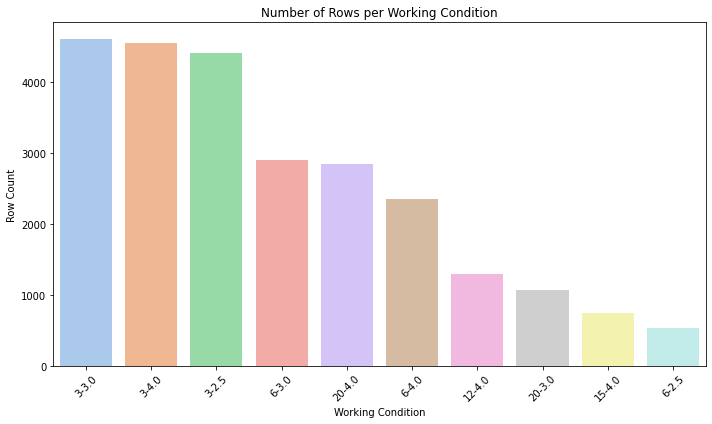

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

condition_counts = df_raw['WorkingCondition'].value_counts().reset_index()
condition_counts.columns = ['WorkingCondition', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=condition_counts, x='WorkingCondition', y='Count', palette='pastel')
plt.title('Number of Rows per Working Condition')
plt.xlabel('Working Condition')
plt.ylabel('Row Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3-2. 여러 센서의 평균값을 WorkingCondition별로 비교 (히트맵)

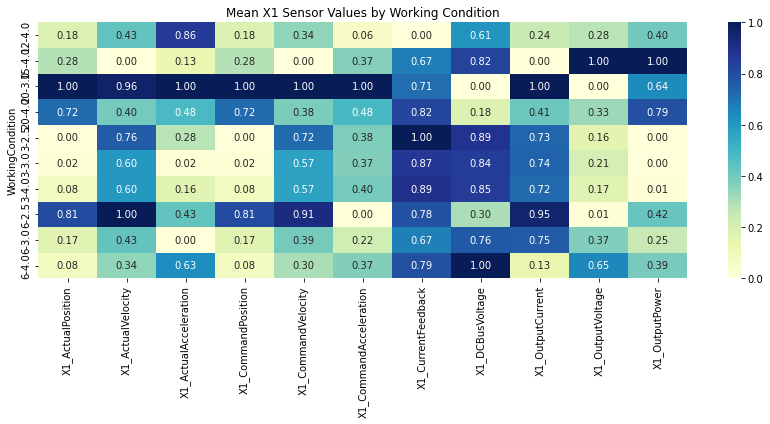

In [12]:
sensor_cols = [col for col in df_raw.columns if col.startswith('X1_')]

# 평균값 집계
sensor_means = df_raw.groupby('WorkingCondition')[sensor_cols].mean()

# 정규화 (각 센서 컬럼별로 0~1 범위로)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sensor_means_scaled = pd.DataFrame(
    scaler.fit_transform(sensor_means),
    index=sensor_means.index,
    columns=sensor_means.columns
)

# 히트맵
plt.figure(figsize=(12, 6))
sns.heatmap(sensor_means_scaled, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Mean X1 Sensor Values by Working Condition')
plt.tight_layout()
plt.show()

### 3-3. Working Condition 별 분포 비교 (t-sne 시각화)

시계열 기반 절삭 데이터(df_layer)에서 센서 데이터를 표준화하고, **t-SNE(차원 축소 기법)** 를 이용해 2차원으로 시각화할 수 있도록 전처리하는 작업을 수행   
센서 데이터의 패턴을 시각화하고, 이를 실험 조건(Experiment)과 레이블(label)에 따라 나누어 분석

In [13]:
import random
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Sensor Data
y = df_layer['label']
list_scn = df_layer['SCN']
df_feature = df_layer[col_sensor].copy(deep = True)

# Standard Scale
standard_scaler = StandardScaler()
df_scaled = pd.DataFrame(standard_scaler.fit_transform(df_feature),columns=df_feature.columns)

df_scaled['SCN'] = list_scn.values
df_scaled['Experiment'] = df_layer['Experiment'].values

choice = random.sample(range(0,len(df_scaled)),8000)

In [14]:
df_tsne = df_scaled.iloc[choice]
tsne_np = TSNE(n_components = 2).fit_transform(df_tsne[col_sensor])
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

# class target 정보 불러오기
tsne_df['target'] = df_tsne['Experiment'].apply(lambda x: str(df_meta[df_meta["No"] == x]['WorkingCondition'].values[0])).values
tsne_df['label']  = df_tsne['Experiment'].apply(lambda x: str(df_meta[df_meta["No"] == x]['label'].values[0])).values
tsne_df['TMP']    = tsne_df['label']+tsne_df['target']

3-2.5 15-4.0


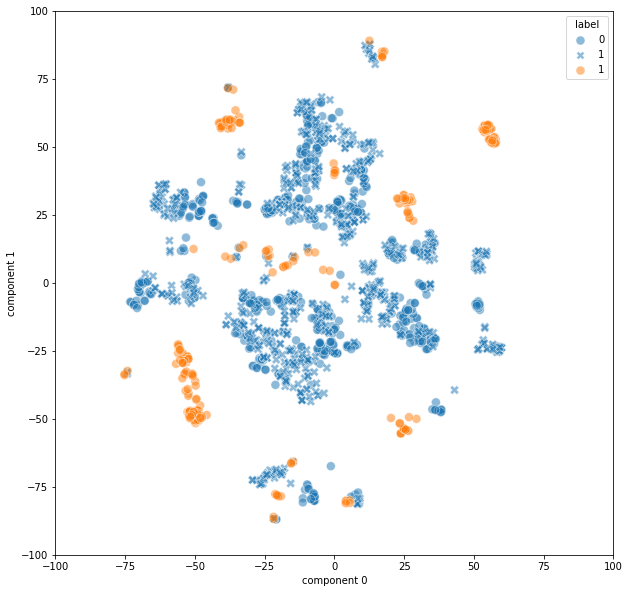

In [15]:
list_df = []
# target 별 분리
for idx in tsne_df['target'].unique():
    list_df.append(tsne_df[tsne_df['target'] == idx])

print(tsne_df['target'].unique()[6], tsne_df['target'].unique()[8])

plt.figure(figsize=(10,10))
# target 별 시각화
for idx in [6,8]:
    df_plot = list_df[idx]
    df_plot=df_plot.sort_values(by = 'label')
    sns.scatterplot(x=df_plot['component 0'],y=df_plot['component 1'], style=df_plot['label'], s = 80, alpha = 0.5)

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

추가 작업

In [16]:
sensor_cols = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
               'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent']

# 1) 라벨별 센서값 평균, 표준편차 계산
stats = df_layer.groupby('label')[sensor_cols].agg(['mean', 'std'])
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = stats.round(3)

# 2) 라벨별 데이터 개수
counts = df_layer.groupby('label').size().rename('count')

# 3) 전체 데이터 수
total_count = counts.sum()

# 4) 비율 컬럼 추가 (소수점 2자리)
ratio = (counts / total_count * 100).round(2).rename('ratio(%)')

# 5) 개수와 비율 컬럼을 통계 테이블에 병합
stats = stats.join([counts, ratio])

# 6) 인덱스 초기화
stats = stats.reset_index()

stats

,label,X1_ActualPosition_mean,X1_ActualPosition_std,X1_ActualVelocity_mean,X1_ActualVelocity_std,X1_ActualAcceleration_mean,X1_ActualAcceleration_std,X1_CurrentFeedback_mean,X1_CurrentFeedback_std,X1_DCBusVoltage_mean,X1_DCBusVoltage_std,X1_OutputCurrent_mean,X1_OutputCurrent_std,count,ratio(%)
0,0,159.429,19.232,-0.185,4.815,-0.800,89.062,-0.340,4.212,0.065,0.037,327.003,1.258,8042,45.9
1,1,156.059,17.019,-0.367,5.929,1.149,101.112,-0.558,4.358,0.070,0.035,326.711,1.638,9478,54.1


C:\Users\DANIK\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DANIK\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DANIK\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DANIK\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DANIK\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 482

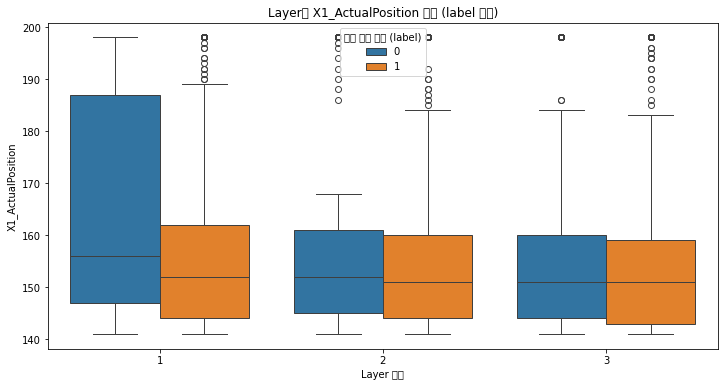

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_layer, x='Layer_Info', y='X1_ActualPosition', hue='label')
plt.title('Layer별 X1_ActualPosition 분포 (label 구분)')
plt.xlabel('Layer 번호')
plt.ylabel('X1_ActualPosition')
plt.legend(title='공구 마모 상태 (label)')
plt.show()


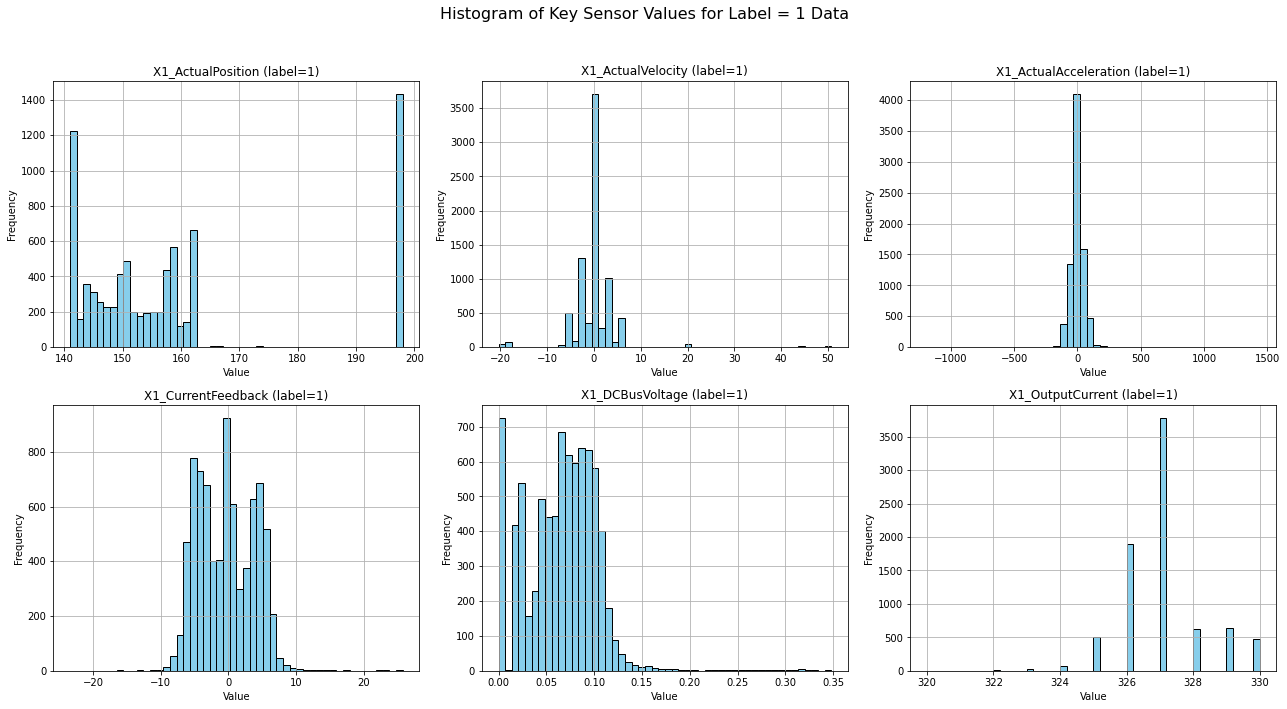

In [18]:
import matplotlib.pyplot as plt

sensor_cols = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
               'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent']

df_label1 = df_layer[df_layer['label'] == 0]

# 히스토그램 시각화
plt.figure(figsize=(18, 10))

for i, col in enumerate(sensor_cols):
    plt.subplot(2, 3, i + 1)
    plt.hist(df_label1[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{col} (label=1)")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.suptitle("Histogram of Key Sensor Values for Label = 1 Data", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


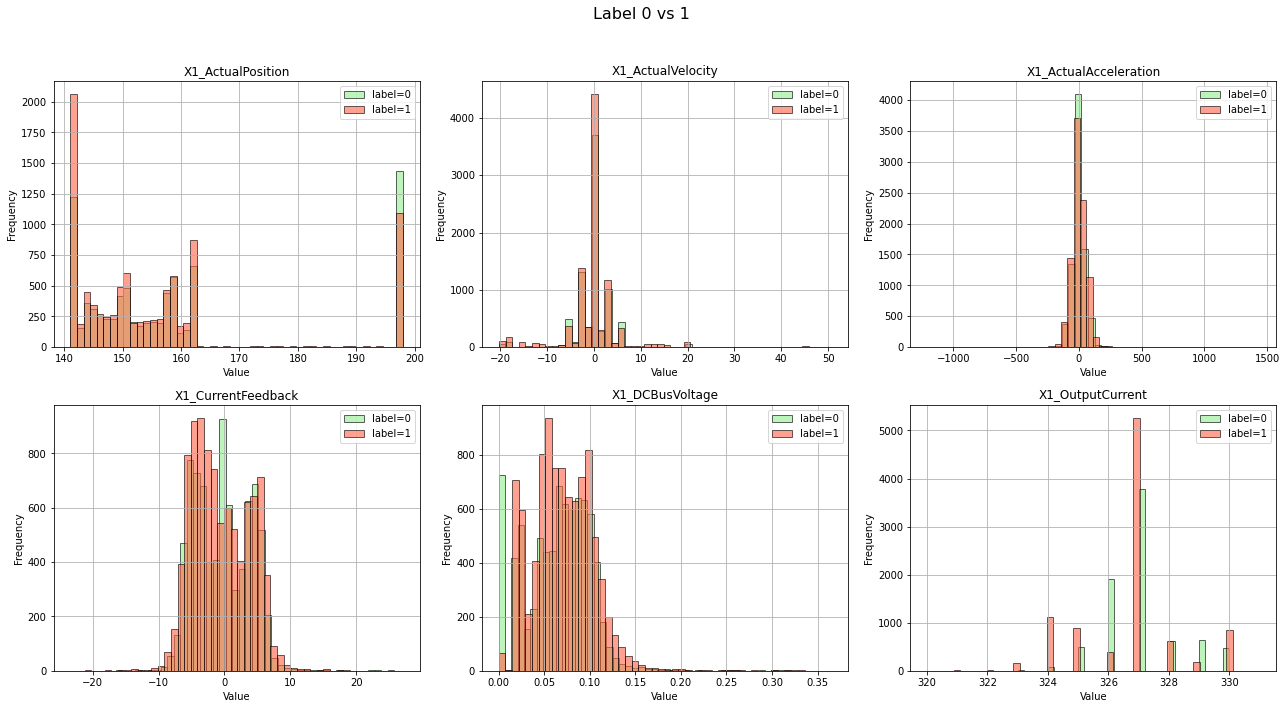

In [19]:
import matplotlib.pyplot as plt

sensor_cols = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
               'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent']

df_label0 = df_layer[df_layer['label'] == 0]
df_label1 = df_layer[df_layer['label'] == 1]

plt.figure(figsize=(18, 10))

for i, col in enumerate(sensor_cols):
    plt.subplot(2, 3, i + 1)
    plt.hist(df_label0[col], bins=50, alpha=0.6, label='label=0', color='lightgreen', edgecolor='black')
    plt.hist(df_label1[col], bins=50, alpha=0.6, label='label=1', color='tomato', edgecolor='black')
    plt.title(f"{col}")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

plt.suptitle("Label 0 vs 1 ", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


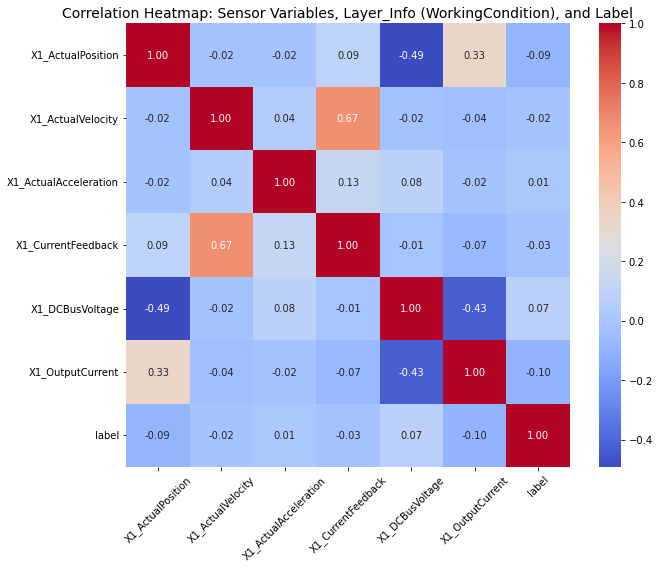

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. 사용할 변수 리스트
sensor_cols = [
    'X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
    'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent'
]

# 2. Layer_Info (WorkingCondition)와 label 컬럼 포함
cols_for_corr = sensor_cols + ['label']

# 3. 상관계수 계산
corr = df_layer[cols_for_corr].corr()

# 4. 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap: Sensor Variables, Layer_Info (WorkingCondition), and Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


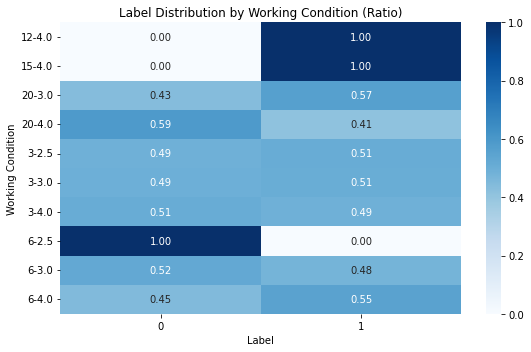

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 라벨 분포 계산 (운영 조건별 라벨 비율)
label_dist = df_raw.groupby(['WorkingCondition', 'label']).size().unstack(fill_value=0)

# 비율 계산
label_ratio = label_dist.div(label_dist.sum(axis=1), axis=0)  # 행 기준 정규화

# 히트맵 시각화
plt.figure(figsize=(8, 5))
sns.heatmap(label_ratio, annot=True, fmt=".2f", cmap="Blues")
plt.title("Label Distribution by Working Condition (Ratio)")
plt.ylabel("Working Condition")
plt.xlabel("Label")
plt.tight_layout()
plt.show()


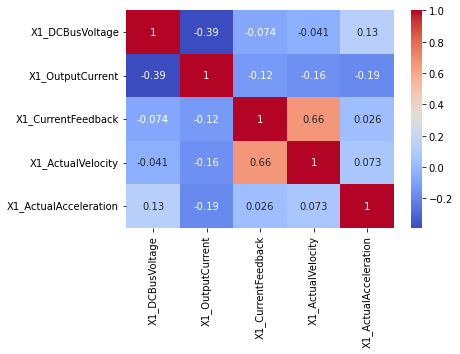

In [24]:
voltage_related = ['X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_CurrentFeedback', 'X1_ActualVelocity', 'X1_ActualAcceleration']
sns.heatmap(df[voltage_related].corr(), annot=True, cmap='coolwarm')
# plt.title("전압 관련 변수 간 상관관계")
plt.show()
